In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

In [24]:
# Load the data
data = pd.read_csv(
    path + '/household_power_consumption.txt',
    sep=';',
    low_memory=False,
    na_values=['nan', '?']
)

# Combine 'Date' and 'Time' into a single datetime column
data['dt'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop the original 'Date' and 'Time' columns
data.drop(columns=['Date', 'Time'], inplace=True)

# Set 'dt' as the index
data.set_index('dt', inplace=True)

# Display the first few rows to confirm the result
print(data.head())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [25]:
print(data.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [26]:
# Drop rows with NaN values
data.dropna(inplace=True)
columns = ['Global_active_power']

# Scale the data
scaler = MinMaxScaler()
data[columns] = scaler.fit_transform(data[columns])

# Convert to sequences for time series modeling
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length, 0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 10  # Number of time steps in each sequence
X, y = create_sequences(data[columns].values, seq_length)

print(f"Sequences shape: {X.shape}, Targets shape: {y.shape}")

Sequences shape: (2049270, 10, 1), Targets shape: (2049270,)


In [27]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader for training
batch_size = 256
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Define Cell

In [28]:
# Reference: https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch/tree/main

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        """
        Custom implementation of an RNN cell. 
        Refer to the PyTorch documentation for nn.RNNCell for more details. 
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNNCell

        Args:
            input_size: Number of input features.
            hidden_size: Number of features in the hidden state.
            bias: Whether to include a bias term (default: True).
            nonlinearity: Nonlinearity to use ('tanh' or 'relu').
        """
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        if nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity. Choose 'tanh' or 'relu'.")

        self.nonlinearity = nonlinearity

        # Linear transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=bias)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters using a uniform distribution.
        """
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden_state_input=None):
        """
        Forward pass for the RNN cell.

        Args:
            input: Input tensor of shape (batch_size, input_size).
            hidden_state_input: Hidden state tensor of shape (batch_size, hidden_size). Defaults to zeros if not provided.

        Returns:
            hidden_state_input: Updated hidden state (batch_size, hidden_size).
        """
        if hidden_state_input is None:
            hidden_state_input = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        # Compute the new hidden state
        hidden_state = self.input_to_hidden(input) + self.hidden_to_hidden(hidden_state_input)
        hidden_state = torch.tanh(hidden_state) if self.nonlinearity == "tanh" else torch.relu(hidden_state)

        return hidden_state

In [29]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        """
        Custom implementation of an LSTM cell.

        Args:
            input_size: Number of input features.
            hidden_size: Number of features in the hidden state.
            bias: Whether to include a bias term (default: True).
        """
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Linear layers for input-to-hidden and hidden-to-hidden transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size * 4, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters using a uniform distribution.
        """
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden_state_tuple=None):
        """
        Forward pass for the LSTM cell.

        Args:
            input: Input tensor of shape (batch_size, input_size).
            hidden_state_tuple: Tuple (hidden state, cell state), each of shape (batch_size, hidden_size).
                Defaults to zeros if not provided.

        Returns:
            hidden_state_next: Updated hidden state (batch_size, hidden_size).
            cell_state_next: Updated cell state (batch_size, hidden_size).
        """
        # If hidden state is not provided, initialize it to zeros (the first time step)
        if hidden_state_tuple is None:
            hidden_state_tuple = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hidden_state_tuple = (hidden_state_tuple, hidden_state_tuple)

        hidden_state_tuple, cell_state_prev = hidden_state_tuple

        # Compute gates
        # TODO: Should we use a single linear layer and split the output? (for efficiency). Or create separate weights for each gate?
        gates = self.input_to_hidden(input) + self.hidden_to_hidden(hidden_state_tuple)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, dim=1)

        # Apply nonlinearities
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        # Update cell state and hidden state
        # k_t = f_t * cell_state_prev
        # j_t = i_t * g_t
        cell_state_next = f_t * cell_state_prev + i_t * g_t
        hidden_state_next = o_t * torch.tanh(cell_state_next)

        return hidden_state_next, cell_state_next

In [30]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        """
        Custom implementation of a GRU cell.

        Args:
            input_size: Number of input features.
            hidden_size: Number of features in the hidden state.
            bias: Whether to include a bias term (default: True).
        """
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Linear transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size * 3, bias=bias)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size * 3, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters using a uniform distribution.
        """
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden_state=None):
        """
        Forward pass for the GRU cell.

        Args:
            input: Input tensor of shape (batch_size, input_size).
            hidden_state: Hidden state tensor of shape (batch_size, hidden_size). Defaults to zeros if not provided.

        Returns:
            hy: Updated hidden state (batch_size, hidden_size).
        """
        if hidden_state is None:
            hidden_state = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        # Compute gate activations
        # TODO: Should we use a single linear layer and split the output? (for efficiency). Or create separate weights for each gate?
        x_t = self.input_to_hidden(input)
        h_t = self.hidden_to_hidden(hidden_state)
        x_reset, x_upd, x_new = x_t.chunk(3, dim=1)
        h_reset, h_upd, h_new = h_t.chunk(3, dim=1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + reset_gate * h_new)

        # Update hidden state
        next_hidden_state = update_gate * hidden_state + (1 - update_gate) * new_gate

        return next_hidden_state

## Define Model

In [31]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size, activation="tanh"):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Create RNN layers
        self.rnn_cell_list = nn.ModuleList([
            RNNCell(input_size if i == 0 else hidden_size, hidden_size, bias, activation)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)

        hidden = [hx[layer, :, :] for layer in range(self.num_layers)]
        outputs = []

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                hidden[layer] = self.rnn_cell_list[layer](
                    input[:, t, :] if layer == 0 else hidden[layer - 1], hidden[layer]
                )
            outputs.append(hidden[-1])

        out = self.fc(outputs[-1].squeeze(1))
        return out

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Create LSTM layers
        self.rnn_cell_list = nn.ModuleList([
            LSTMCell(input_size if i == 0 else hidden_size, hidden_size, bias)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)
        hidden = [(hx[layer, :, :], hx[layer, :, :]) for layer in range(self.num_layers)]
        outputs = []

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                hidden[layer] = self.rnn_cell_list[layer](
                    input[:, t, :] if layer == 0 else hidden[layer - 1][0], hidden[layer]
                )
            outputs.append(hidden[-1][0])

        out = self.fc(outputs[-1].squeeze(1))
        return out

In [33]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Create GRU layers
        self.rnn_cell_list = nn.ModuleList([
            GRUCell(input_size if i == 0 else hidden_size, hidden_size, bias)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)
        hidden = [hx[layer, :, :] for layer in range(self.num_layers)]
        outputs = []

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                hidden[layer] = self.rnn_cell_list[layer](
                    input[:, t, :] if layer == 0 else hidden[layer - 1], hidden[layer]
                )
            outputs.append(hidden[-1])

        out = self.fc(outputs[-1].squeeze(1))
        return out

In [34]:
class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Select the appropriate cell type
        cell_cls = {
            "LSTM": LSTMCell,
            "GRU": GRUCell,
            "RNN_TANH": lambda *args: RNNCell(*args, nonlinearity="tanh"),
            "RNN_RELU": lambda *args: RNNCell(*args, nonlinearity="relu"),
        }.get(mode)
        if cell_cls is None:
            raise ValueError("Invalid RNN mode selected.")

        # Create bidirectional RNN layers
        self.rnn_cell_list_fwd = nn.ModuleList([
            cell_cls(input_size if i == 0 else hidden_size, hidden_size, bias)
            for i in range(num_layers)
        ])
        self.rnn_cell_list_bwd = nn.ModuleList([
            cell_cls(input_size if i == 0 else hidden_size, hidden_size, bias)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)
            
        if self.mode != "LSTM":
            hidden_fwd = [hx[layer, :, :] for layer in range(self.num_layers)]
            hidden_bwd = [hx[layer, :, :] for layer in range(self.num_layers)]
            outputs_fwd, outputs_bwd = [], []

            for t in range(input.size(1)):
                for layer in range(self.num_layers):
                    hidden_fwd[layer] = self.rnn_cell_list_fwd[layer](
                        input[:, t, :] if layer == 0 else hidden_fwd[layer - 1], hidden_fwd[layer]
                    )
                    hidden_bwd[layer] = self.rnn_cell_list_bwd[layer](
                        input[:, -(t + 1), :] if layer == 0 else hidden_bwd[layer - 1], hidden_bwd[layer]
                    )
                outputs_fwd.append(hidden_fwd[-1][0] if self.mode == "LSTM" else hidden_fwd[-1])
                outputs_bwd.append(hidden_bwd[-1][0] if self.mode == "LSTM" else hidden_bwd[-1])
        else:
            hidden_fwd = [(hx[layer, :, :], hx[layer, :, :]) for layer in range(self.num_layers)]
            hidden_bwd = [(hx[layer, :, :], hx[layer, :, :]) for layer in range(self.num_layers)]
            outputs_fwd, outputs_bwd = [], []

            for t in range(input.size(1)):
                for layer in range(self.num_layers):
                    hidden_fwd[layer] = self.rnn_cell_list_fwd[layer](
                        input[:, t, :] if layer == 0 else hidden_fwd[layer - 1][0], hidden_fwd[layer]
                    )
                    hidden_bwd[layer] = self.rnn_cell_list_bwd[layer](
                        input[:, -(t + 1), :] if layer == 0 else hidden_bwd[layer - 1][0], hidden_bwd[layer]
                    )
                outputs_fwd.append(hidden_fwd[-1][0])
                outputs_bwd.append(hidden_bwd[-1][0])
                
        out_fwd, out_bwd = outputs_fwd[-1], outputs_bwd[0]
        out = torch.cat([out_fwd, out_bwd], dim=1)
        return self.fc(out)

## Train Model

In [35]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            optimizer.zero_grad()
            # Forward pass
            output = model(X_batch.to(model.fc.weight.device))
            loss = criterion(output.squeeze(), y_batch.to(model.fc.weight.device))
            # Backward pass
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

def evaluate_model(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X, dtype=torch.float32, device=model.fc.weight.device)).cpu().squeeze().numpy()
    return predictions

In [36]:
# Model Parameters
input_size = len(columns)
hidden_size = 32
num_layers = 2
output_size = 1
bias = True
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

simple_rnn = SimpleRNN(input_size, hidden_size, num_layers, bias, output_size, activation="tanh").to(device)
lstm = LSTM(input_size, hidden_size, num_layers, bias, output_size).to(device)
gru = GRU(input_size, hidden_size, num_layers, bias, output_size).to(device)
bidir_lstm = BidirRecurrentModel("LSTM", input_size, hidden_size, num_layers, bias, output_size).to(device)

In [37]:
nums_epochs = 1

train_model(simple_rnn, dataloader, epochs=nums_epochs)
simple_rnn_predictions = evaluate_model(simple_rnn, X)

train_model(lstm, dataloader, epochs=nums_epochs)
lstm_predictions = evaluate_model(lstm, X)

train_model(gru, dataloader, epochs=nums_epochs)
gru_predictions = evaluate_model(gru, X)

train_model(bidir_lstm, dataloader, epochs=nums_epochs)
bidir_lstm_predictions = evaluate_model(bidir_lstm, X)

100%|██████████| 8005/8005 [01:00<00:00, 131.63it/s]


Epoch 1/1, Loss: 0.0006


100%|██████████| 8005/8005 [01:48<00:00, 73.94it/s]


Epoch 1/1, Loss: 0.0007


100%|██████████| 8005/8005 [01:52<00:00, 71.40it/s]


Epoch 1/1, Loss: 0.0006


100%|██████████| 8005/8005 [02:19<00:00, 57.20it/s]


Epoch 1/1, Loss: 0.0006


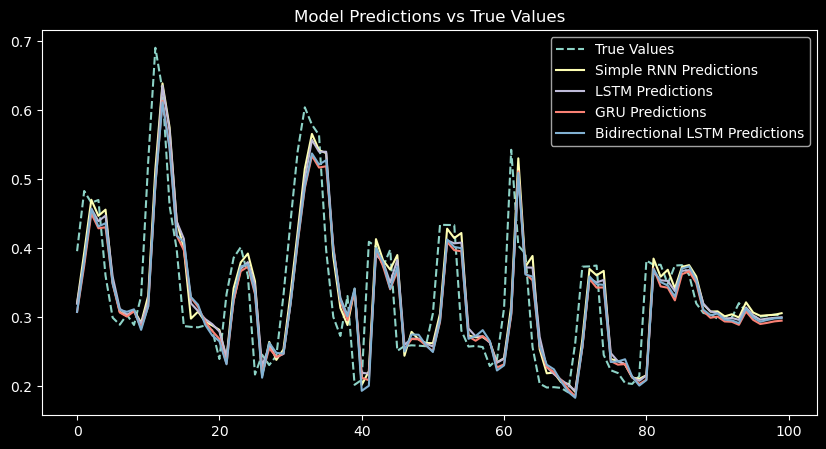

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(y[:100], label='True Values', linestyle='dashed')
plt.plot(simple_rnn_predictions[:100], label='Simple RNN Predictions')
plt.plot(lstm_predictions[:100], label='LSTM Predictions')
plt.plot(gru_predictions[:100], label='GRU Predictions')
plt.plot(bidir_lstm_predictions[:100], label='Bidirectional LSTM Predictions')
plt.legend()
plt.title("Model Predictions vs True Values")
plt.show()

## Train Model with previous output

In [58]:
def train_model_with_recursive_input(model, dataloader, seq_length, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            optimizer.zero_grad()
            # Initialize the input sequence with the first sequence in the batch
            input_seq = X_batch[:, :seq_length, :].to(model.fc.weight.device)
            outputs = []
            for _ in range(0, seq_length, X_batch.size(1)):
                output = model(input_seq)
                outputs.append(output)
                new_input = torch.cat((input_seq[:, 1:, :], output.unsqueeze(1)), dim=1)
                input_seq = new_input
            
            outputs = torch.cat(outputs, dim=1)
            loss = criterion(outputs.squeeze(), y_batch.to(model.fc.weight.device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
        
def evaluate_model_recursive(model, X, seq_length):
    model.eval()
    predictions = []
    with torch.no_grad():
        input_seq = torch.tensor(X[0], dtype=torch.float32, device=model.fc.weight.device).unsqueeze(0)
        for _ in range(len(X)):
            output = model(input_seq)
            predictions.append(output.cpu().squeeze().numpy())
            new_input = torch.cat((input_seq[:, 1:, :], output.unsqueeze(1)), dim=1)
            input_seq = new_input
    return np.array(predictions).flatten()

In [59]:
simple_rnn = SimpleRNN(input_size, hidden_size, num_layers, bias, output_size, activation="tanh").to(device)
lstm = LSTM(input_size, hidden_size, num_layers, bias, output_size).to(device)
gru = GRU(input_size, hidden_size, num_layers, bias, output_size).to(device)
bidir_lstm = BidirRecurrentModel("LSTM", input_size, hidden_size, num_layers, bias, output_size).to(device)

In [63]:
train_model_with_recursive_input(simple_rnn, dataloader, seq_length, epochs=nums_epochs)
train_model_with_recursive_input(lstm, dataloader, seq_length, epochs=nums_epochs)
train_model_with_recursive_input(gru, dataloader, seq_length, epochs=nums_epochs)
train_model_with_recursive_input(bidir_lstm, dataloader, seq_length, epochs=nums_epochs)

100%|██████████| 8005/8005 [00:59<00:00, 134.08it/s]


Epoch 1/1, Loss: 0.0006


100%|██████████| 8005/8005 [01:38<00:00, 80.87it/s]


Epoch 1/1, Loss: 0.0009


100%|██████████| 8005/8005 [01:46<00:00, 75.22it/s]


Epoch 1/1, Loss: 0.0006


100%|██████████| 8005/8005 [02:16<00:00, 58.52it/s]

Epoch 1/1, Loss: 0.0007


In [64]:
numbers_to_predict = 100

# Evaluate models recursively
simple_rnn_recursive_predictions = evaluate_model_recursive(simple_rnn, X[:numbers_to_predict], seq_length)
lstm_recursive_predictions = evaluate_model_recursive(lstm, X[:numbers_to_predict], seq_length)
gru_recursive_predictions = evaluate_model_recursive(gru, X[:numbers_to_predict], seq_length)
bidir_lstm_recursive_predictions = evaluate_model_recursive(bidir_lstm, X[:numbers_to_predict], seq_length)

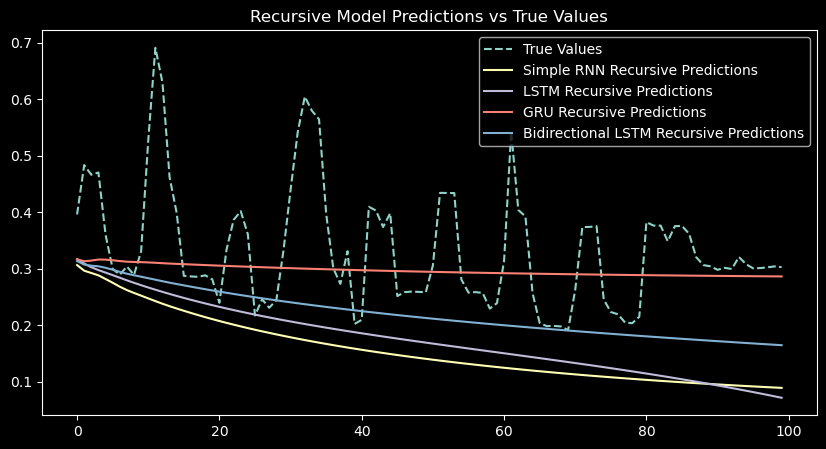

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(y[:numbers_to_predict], label='True Values', linestyle='dashed')
plt.plot(simple_rnn_recursive_predictions[:numbers_to_predict], label='Simple RNN Recursive Predictions')
plt.plot(lstm_recursive_predictions[:numbers_to_predict], label='LSTM Recursive Predictions')
plt.plot(gru_recursive_predictions[:numbers_to_predict], label='GRU Recursive Predictions')
plt.plot(bidir_lstm_recursive_predictions[:numbers_to_predict], label='Bidirectional LSTM Recursive Predictions')
plt.legend()
plt.title("Recursive Model Predictions vs True Values")
plt.show()

## RNN, LSTM, GRU, BiRNN with text data

In [ ]:
# Sample text classification data
text_data = [
    ("I love programming in Python", 1),
    ("Python is a great language", 1),
    ("I enjoy learning new things", 1),
    ("This is a boring task", 0),
    ("I dislike doing repetitive work", 0),
    ("This is not interesting", 0)
]

# Convert to DataFrame for easier manipulation
text_df = pd.DataFrame(text_data, columns=["Text", "Label"])

# Display the DataFrame
print(text_df)

                              Text  Label
0     I love programming in Python      1
1       Python is a great language      1
2      I enjoy learning new things      1
3            This is a boring task      0
4  I dislike doing repetitive work      0
5          This is not interesting      0


In [ ]:
simple_rnn = SimpleRNN(input_size, hidden_size, num_layers, bias, output_size, activation="tanh").to(device)
lstm = LSTM(input_size, hidden_size, num_layers, bias, output_size).to(device)
gru = GRU(input_size, hidden_size, num_layers, bias, output_size).to(device)
bidir_lstm = BidirRecurrentModel("LSTM", input_size, hidden_size, num_layers, bias, output_size).to(device)

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenize the text
text_df["Tokens"] = text_df["Text"].apply(word_tokenize)

# Count the number of unique words
unique_words = set()
text_df["Tokens"].apply(unique_words.update)

# Create a dictionary mapping words to integers
word_to_idx = {word: idx for idx, word in enumerate(unique_words)}

# Convert the tokens to integers
text_df["TokenIdx"] = text_df["Tokens"].apply(lambda x: [word_to_idx[word] for word in x])

# Apply padding to make all sequences the same length
max_length = text_df["TokenIdx"].apply(len).max()
text_df["TokenIdx"] = text_df["TokenIdx"].apply(lambda x: x + [0] * (max_length - len(x)))

# Define the embedding layer and run a forward pass
embedding_layer = nn.Embedding(num_embeddings=len(word_to_idx), embedding_dim=input_size, device=device)
input_sequence = torch.tensor(text_df["TokenIdx"].tolist(), dtype=torch.long, device=device)
embedded_sequence = embedding_layer(input_sequence)

# For all models, run the forward pass and print the output 
for model in [simple_rnn, lstm, gru, bidir_lstm]:
    output = model(embedded_sequence)
    print(model.__class__.__name__)
    print(output)
    print()

SimpleRNN
tensor([[-0.1431],
        [-0.1762],
        [-0.1717],
        [-0.1427],
        [-0.1156],
        [-0.1486]], device='cuda:1', grad_fn=<AddmmBackward0>)

LSTM
tensor([[0.0335],
        [0.0329],
        [0.0305],
        [0.0321],
        [0.0336],
        [0.0325]], device='cuda:1', grad_fn=<AddmmBackward0>)

GRU
tensor([[-0.1575],
        [-0.1787],
        [-0.1764],
        [-0.1736],
        [-0.1527],
        [-0.1620]], device='cuda:1', grad_fn=<AddmmBackward0>)

BidirRecurrentModel
tensor([[0.0136],
        [0.0157],
        [0.0141],
        [0.0159],
        [0.0137],
        [0.0136]], device='cuda:1', grad_fn=<AddmmBackward0>)

